# **informatics-vs-electrical-classifier**


---

## **Presented by**
Faishal Anwar Hasyim

Alif Naufal Adani

Akhmad Syaifudin

Faizal Imam Syafangat

Bintang Bimantara Putra

## **Objective**
Proyek ini bertujuan untuk mengembangkan sistem klasifikasi teks berbasis machine learning untuk mengkategorikan judul penelitian akademik secara otomatis ke dalam dua bidang studi: Teknik Informatika dan Teknik Elektro.

Dengan memanfaatkan algoritma K-Nearest Neighbors (KNN) dan ekstraksi fitur TF-IDF, sistem ini dirancang untuk:

1. Menganalisis pola kata dalam judul penelitian untuk membedakan topik berbasis perangkat lunak/data dengan topik berbasis perangkat keras/kelistrikan.

2. Menyediakan solusi otomatis untuk pengelompokan repositori akademik dan mengurangi kesalahan klasifikasi manual.

3. Mencapai akurasi klasifikasi yang tinggi melalui tahapan preprocessing yang ketat, pelabelan berbasis kamus (dictionary-based labeling), dan optimasi hyperparameter.

# 1. Import Libraries

In [32]:
# Install & Import
!pip install sastrawi wordcloud

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Setup Stopwords
factory_stop = StopWordRemoverFactory()
stopword_sastrawi = factory_stop.create_stop_word_remover()

print("Library siap.")

Library siap.


# 2. Loading Dataset & Preprocessing

In [33]:
# Load & Preprocessing
try:
    df = pd.read_csv('datasetdosen.csv', encoding='utf-8')
    df = df[['judul']].dropna().drop_duplicates()
except:
    # Dummy data darurat
    df = pd.DataFrame({'judul': ['Sistem Informasi Web', 'Kendali Motor DC']})

# 2. Kamus Singkatan (Diperluas)
kamus_singkatan = {
    "yg": "yang", "dgn": "dengan", "thd": "terhadap", "dlm": "dalam",
    "kpd": "kepada", "utk": "untuk", "dr": "dari", "sdh": "sudah",
    "tdk": "tidak", "gak": "tidak", "tak": "tidak", "tp": "tapi",
    "krn": "karena", "hub": "hubungan", "mhs": "mahasiswa",
    "rancang": "perancangan", "bangun": "pembangunan", "sys": "sistem"
}

# 3. Fungsi Cleaning
def preprocess_text_advanced(text):
    if not isinstance(text, str): return ""
    text = text.lower()

    # Hapus angka & simbol aneh (pertahankan spasi)
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Perbaiki singkatan
    words = text.split()
    words = [kamus_singkatan.get(w, w) for w in words]

    # Hapus stopwords umum (Sastrawi)
    text = stopword_sastrawi.remove(' '.join(words))

    # Hapus kata terlalu pendek (1-2 huruf) kecuali istilah teknis (misal 'ui', 'ux', 'ai')
    whitelist_short = ['ui', 'ux', 'ai', 'ip', 'it', 'rf', 'dc', 'ac', 'ic']
    final_words = [w for w in text.split() if len(w) > 2 or w in whitelist_short]

    return " ".join(final_words)

print("Membersihkan teks...")
df['judul_clean'] = df['judul'].apply(preprocess_text_advanced)
print("Selesai. Contoh:")
print(df[['judul', 'judul_clean']].head())

Membersihkan teks...
Selesai. Contoh:
                                               judul  \
0  Sistem Informasi Rental Mobil Terintegrasi pad...   
1  Studi Awal Perencanaan sistem Mekanikal dan Ke...   
2  Analisa Pengaruh Kualitas Batubara Terhadap Bi...   
3  Review of method for system identification on ...   
4  Pengendalian Suhu Dalam Ruang Berbasis Logika ...   

                                         judul_clean  
0  sistem informasi rental mobil terintegrasi ren...  
1  studi awal perencanaan sistem mekanikal kelist...  
2  analisa pengaruh kualitas batubara biaya pemba...  
3     review method for system identification motors  
4  pengendalian suhu ruang berbasis logika fuzzy ...  


# 3. Data Labeling

In [34]:
# Weighted Auto-Labeling

# Kamus dengan Bobot (Keyword: Score)
# Skor Positif (+1) -> Informatika
# Skor Negatif (-1) -> Elektro

keywords_weighted = {
    # INFORMATIKA (Score +)
    'web': 1, 'website': 1, 'android': 2, 'mobile': 1, 'ios': 2,
    'sistem informasi': 2, 'informasi': 1, 'aplikasi': 1, 'rpl': 2,
    'mining': 2, 'data': 1, 'klasifikasi': 1, 'clustering': 1, 'algoritma': 1,
    'knn': 2, 'svm': 2, 'bayes': 2, 'neural': 2, 'deep learning': 2,
    'expert': 1, 'pakar': 1, 'spk': 2, 'keputusan': 1, 'saw': 2, 'ahp': 2,
    'citra': 1, 'image': 1, 'deteksi': 1, 'yolo': 2, 'cnn': 2,
    'keamanan': 1, 'security': 1, 'kriptografi': 2, 'enkripsi': 2,
    'ui': 2, 'ux': 2, 'user': 1, 'game': 1, 'virtual': 1, 'augmented': 1,

    # ELEKTRO (Score -)
    'listrik': -2, 'tegangan': -2, 'arus': -2, 'daya': -1, 'energi': -1,
    'pembangkit': -2, 'transmisi': -2, 'distribusi': -2, 'gardu': -2,
    'mikrokontroler': -2, 'arduino': -2, 'atmega': -2, 'raspberry': -1,
    'plc': -3, 'scada': -3, 'kendali': -2, 'kontrol': -1, 'pid': -3,
    'sensor': -1, 'ultrasonik': -1, 'robot': -2, 'lengan': -1, 'drone': -1,
    'inverter': -2, 'konverter': -2, 'motor': -2, 'dc': -2, 'ac': -1,
    'antena': -2, 'mikrostrip': -2, 'frekuensi': -1, 'sinyal': -1, 'telekomunikasi': -1,
    'panel': -1, 'surya': -1, 'photovoltaic': -2, 'plts': -2, 'baterai': -1,
    'elektronika': -2, 'sirkuit': -1, 'rangkaian': -1, 'otomasi': -2
}

def get_label_weighted(text):
    score = 0
    # Cek n-gram (frase) dulu
    if 'sistem informasi' in text: score += 2
    if 'teknik informatika' in text: score += 5
    if 'teknik elektro' in text: score -= 5

    # Cek per kata
    words = text.split()
    for w in words:
        # Ambil skor dari kamus, jika tidak ada skornya 0
        score += keywords_weighted.get(w, 0)

    if score > 0: return 'Teknik Informatika'
    elif score < 0: return 'Teknik Elektro'
    else:
        # Tie-breaker sederhana
        if 'informasi' in text: return 'Teknik Informatika'
        if 'teknik' in text and 'kendali' in text: return 'Teknik Elektro'
        return 'Unknown'

print("Melakukan labeling...")
df['label_final'] = df['judul_clean'].apply(get_label_weighted)

# Filter valid data
df_ready = df[df['label_final'] != 'Unknown'].copy()
print(f"Data siap: {len(df_ready)}")
print(df_ready['label_final'].value_counts())

Melakukan labeling...
Data siap: 420
label_final
Teknik Informatika    220
Teknik Elektro        200
Name: count, dtype: int64


# 4. Data Splitting

In [35]:
# TF-IDF N-Gram

# Encode Label
le = LabelEncoder()
df_ready['label_code'] = le.fit_transform(df_ready['label_final'])
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))

# TF-IDF dengan N-Gram (Uni-gram & Bi-gram)
# Contoh: membaca "machine learning" sebagai satu fitur
tfidf = TfidfVectorizer(max_features=1500, ngram_range=(1, 2))

X = tfidf.fit_transform(df_ready['judul_clean']).toarray()
y = df_ready['label_code']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Fitur N-Gram TF-IDF berhasil dibuat.")

Fitur N-Gram TF-IDF berhasil dibuat.


# 5. Modeling & Evaluation

Mencari nilai K terbaik...


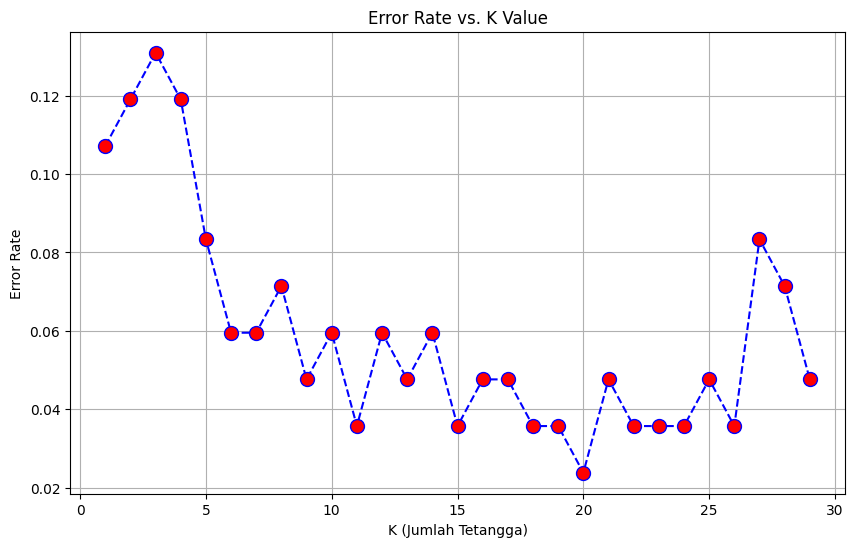

Nilai K terbaik adalah: 20


In [36]:
# Tuning Nilai K

error_rate = []
k_range = range(1, 30) # Coba K dari 1 sampai 29

print("Mencari nilai K terbaik...")
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

# Plot Error Rate
plt.figure(figsize=(10, 6))
plt.plot(k_range, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K (Jumlah Tetangga)')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

# Ambil K dengan error terkecil
best_k = k_range[np.argmin(error_rate)]
print(f"Nilai K terbaik adalah: {best_k}")

=== Classification Report ===
                    precision    recall  f1-score   support

    Teknik Elektro       0.98      0.98      0.98        43
Teknik Informatika       0.98      0.98      0.98        41

          accuracy                           0.98        84
         macro avg       0.98      0.98      0.98        84
      weighted avg       0.98      0.98      0.98        84



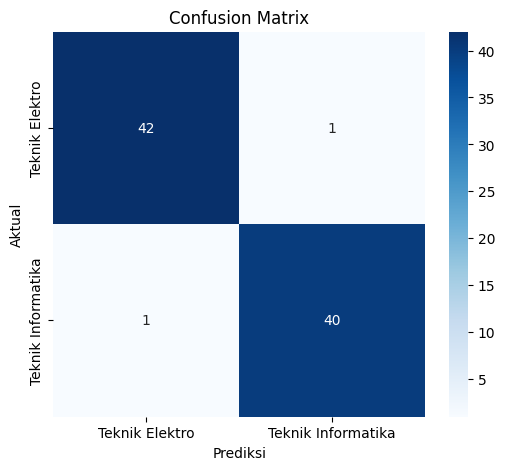

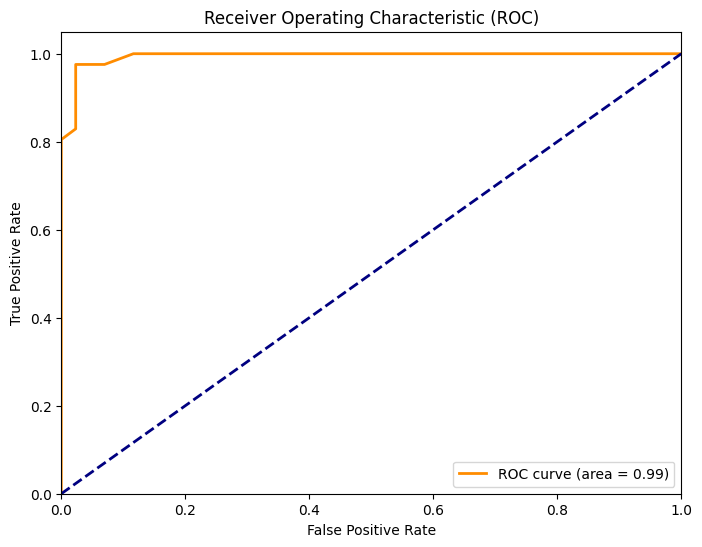

In [37]:
# Final Model & Evaluation

# Train dengan Best K
final_model = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1] # Probabilitas untuk ROC Curve

# 1. Classification Report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 2. Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

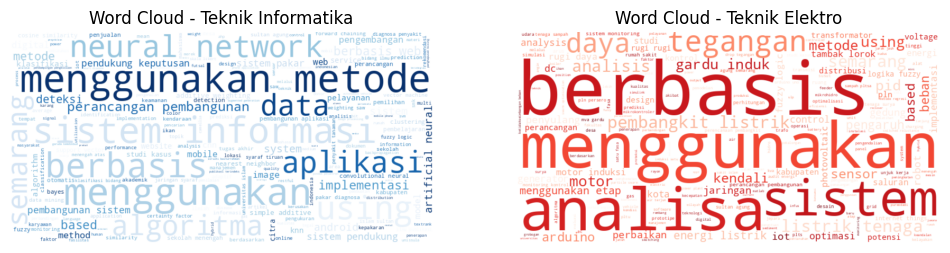

In [38]:
# Word Cloud Visualization

# Pisahkan teks berdasarkan label
text_ti = " ".join(df_ready[df_ready['label_final']=='Teknik Informatika']['judul_clean'])
text_te = " ".join(df_ready[df_ready['label_final']=='Teknik Elektro']['judul_clean'])

# WordCloud TI
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wc_ti = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(text_ti)
plt.imshow(wc_ti, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Teknik Informatika')

# WordCloud TE
plt.subplot(1, 2, 2)
wc_te = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_te)
plt.imshow(wc_te, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Teknik Elektro')

plt.show()

# 6. Simulasi dengan data actuan (nyata)

In [39]:
# Simulasi Data Baru

print(f"Menggunakan Model KNN dengan K={best_k}")
print("="*40)

while True:
    txt = input("\nMasukkan Judul (ketik 'exit' keluar): ")
    if txt.lower() == 'exit': break

    # 1. Preprocess
    clean = preprocess_text_advanced(txt)
    if not clean.strip():
        print("Input terlalu pendek/tidak valid.")
        continue

    # 2. Vectorize
    vec = tfidf.transform([clean]).toarray()

    # 3. Predict
    pred_idx = final_model.predict(vec)[0]
    pred_label = label_mapping[pred_idx]

    # 4. Probabilitas (Keyakinan Model)
    probs = final_model.predict_proba(vec)[0]
    confidence = np.max(probs) * 100

    print(f"--> Klasifikasi: [{pred_label.upper()}]")
    print(f"    Tingkat Keyakinan: {confidence:.1f}%")
    print(f"    (Clean: {clean})")

Menggunakan Model KNN dengan K=20

Masukkan Judul (ketik 'exit' keluar): Pengembangan Aplikasi Android untuk Pemesanan Tiket Bioskop Berbasis Firebase.
--> Klasifikasi: [TEKNIK INFORMATIKA]
    Tingkat Keyakinan: 90.0%
    (Clean: pengembangan aplikasi android pemesanan tiket bioskop berbasis firebase)

Masukkan Judul (ketik 'exit' keluar): Sistem Keamanan Jaringan Menggunakan Metode Kriptografi AES-256.
--> Klasifikasi: [TEKNIK INFORMATIKA]
    Tingkat Keyakinan: 90.0%
    (Clean: sistem keamanan jaringan menggunakan metode kriptografi aes)

Masukkan Judul (ketik 'exit' keluar): Perancangan Sistem Kendali Kecepatan Motor DC Menggunakan PID Controller.
--> Klasifikasi: [TEKNIK ELEKTRO]
    Tingkat Keyakinan: 85.0%
    (Clean: perancangan sistem kendali kecepatan motor dc menggunakan pid controller)

Masukkan Judul (ketik 'exit' keluar): Sistem Monitoring Arus dan Daya Listrik Rumah Tangga Berbasis IoT (Hardware Focus).
--> Klasifikasi: [TEKNIK ELEKTRO]
    Tingkat Keyakinan: 85.0%
    

# 7. Model Save

In [40]:
import joblib

# Simpan model
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']

In [41]:
!pip freeze > requirements.txt